### Project - Predict heart attack based on phisiological and physical parameters of the patient

https://www.kaggle.com/sulianova/cardiovascular-disease-dataset

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

%matplotlib inline

In [130]:
import warnings
warnings.filterwarnings('ignore')

In [131]:
df_stroke = pd.read_csv('stroke_data_for_modeling.csv', sep=';')

### Machine learning models - action plan

1. Train each model. This is a classification problem and we are interested in maximizing the recall, ideally, we want to diagnose as many patients as possible.

2. Error Measurements:
3. Confusion matrix - calculate and plot 
4. RandomizedSearchCV - tune hyperparameters to optimize recall
5. cross validation score
   
6. Set a dictionary with name of ML models and each error
7. After error evaluation, select the best model and save it

In [132]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Create target object and call it y
y = df_stroke['Target']
# Create X
#features = ['Age', 'Sex', 'SystolicPressure', 'Cholesterol', 'Diabetes']
features = ['Age', 'Sex', 'Height', 'Weight','SystolicPressure', 'DiastolicPressure', 'Cholesterol', 'Diabetes', 'Smoker', 'Alcoholic',
           'ActiveSport']
X = df_stroke[features]

# Split into validation and training data
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=1)

#Create a data frame which will store all the model scores
model_score = pd.DataFrame(index = ['Model Score'])

**Decision Tree Classifier**

In [141]:
from sklearn.tree import DecisionTreeClassifier

# Specify Model
tree_model = DecisionTreeClassifier(random_state=1)
# Fit Model
tree_model.fit(train_X, train_y)

# Make validation predictions and calculate mean squared error
val_predictions = tree_model.predict(test_X)
val_mse = accuracy_score(val_predictions, test_y)
print("Validation accuracy: {:,.3f}".format(val_mse))


Validation accuracy: 0.623


In [142]:
#We define a function that returns the Mean square error of the decision tree
def get_accuracy_tree(max_leaf_nodes, train_X, test_X, train_y, test_y):
    model = DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(test_X)
    acc = accuracy_score(test_y, preds_val)
    return(acc)

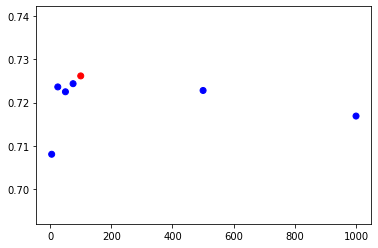

In [143]:
#The error in the first approach is quite high. Let us iterate to find the optimal tree parameters

candidate_max_leaf_nodes = [5, 25, 50,75, 100, 500,1000]
# Write loop to find the ideal tree size from candidate_max_leaf_nodes
acc=[]
for x in candidate_max_leaf_nodes:
    acc.append(get_accuracy_tree(x,train_X, test_X, train_y, test_y))

# Store the best value of max_leaf_nodes 
best_tree_size = candidate_max_leaf_nodes[acc.index(max(acc))]

#Show the minimum accuracy highlighted in red
maxAcc = np.max(acc)
mask = np.array(acc) == maxAcc
color = np.where(mask, 'red', 'blue')
plt.scatter(candidate_max_leaf_nodes,acc, color=color)


In [144]:
#Create tree model with the best max_leaf_nodes
improved_tree_model = DecisionTreeClassifier(max_leaf_nodes=best_tree_size, random_state=1)

# fit the final model with the whole dataset and calculate error
improved_tree_model.fit(train_X, train_y)
val_predictions = improved_tree_model.predict(test_X)
val_acc = accuracy_score(val_predictions, test_y)
print("Validation accuracy: {:,.5f} - Best tree size: {:,.0f}".format(val_acc,best_tree_size))

Validation accuracy: 0.72618 - Best tree size: 100


In [145]:
#Print the score for the model with an improved leaf nodes size
improved_tree_model.score(test_X,test_y)

0.7261771090650497

In [146]:
#Let us use Randomized Grid search to optimize several hyperparameters

# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_leaf_nodes" : np.arange(10,200,10),
              "max_depth": np.arange(1, 10),
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = RandomizedSearchCV(tree_model, param_dist, cv=5, random_state=1)

# Fit it to the data
tree_cv.fit(train_X,train_y)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))


Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 9, 'max_features': 7, 'max_leaf_nodes': 80, 'min_samples_leaf': 4}
Best score is 0.7308217768045964


In [147]:
print(confusion_matrix(test_y,val_predictions))
print(classification_report(test_y,val_predictions))

[[4695 1772]
 [1886 5006]]
              precision    recall  f1-score   support

           0       0.71      0.73      0.72      6467
           1       0.74      0.73      0.73      6892

    accuracy                           0.73     13359
   macro avg       0.73      0.73      0.73     13359
weighted avg       0.73      0.73      0.73     13359



In [148]:
#Create tree model with the best hyperparameters
best_tree_model = tree_cv.best_estimator_.fit(train_X,train_y)

# fit the final model with the whole dataset and calculate error
val_predictions = best_tree_model.predict(test_X)
val_acc = accuracy_score(val_predictions, test_y)
print("Validation accuracy: {:,.5f}".format(val_acc))

Validation accuracy: 0.72228


In [149]:
#Also check the model with cross validation and store the mean of the values as the score of the model
cross_val_score(best_tree_model, X, y, cv=10, scoring='recall').mean()

0.7035085581263287

In [150]:
model_score['DecisionTree'] =  [val_acc]

In [151]:
model_score

,K-Neighbors,DecisionTree
Model Score,0.640243,0.722285


**Random Forest**

In [152]:
# Create target object and call it y
y = df_stroke['Target']
# Create X
#features = ['Age', 'Sex', 'SystolicPressure', 'Cholesterol', 'Diabetes']
features = ['Age', 'Sex', 'Height', 'Weight','SystolicPressure', 'DiastolicPressure', 'Cholesterol', 'Diabetes', 'Smoker', 'Alcoholic',
           'ActiveSport']
X = df_stroke[features]

In [153]:
from sklearn.ensemble import RandomForestClassifier

# Define the model. Set random_state to 1
rf_model = RandomForestClassifier(random_state=1)

# fit the model
rf_model.fit(train_X,train_y)

# Calculate the mean squared error of your Random Forest model on the validation data
predict_y=rf_model.predict(test_X)
rf_val_mse = accuracy_score(test_y,predict_y)

print("Validation accuracy for Random Forest Model: {}".format(rf_val_mse))


Validation accuracy for Random Forest Model: 0.6775207725129127


In [154]:
#We define a function that returns the Mean squared error of the Random Forest. We will check for this purpose
# two parameters of the Random Forest regressor, the depth and the leaf nodes
def get_accuracy_forest(max_depth, max_leaf_nodes, train_X, test_X, train_y, test_y):
    model = RandomForestClassifier(max_depth=max_depth, max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(test_X)
    mse = accuracy_score(test_y, preds_val)
    return(mse)

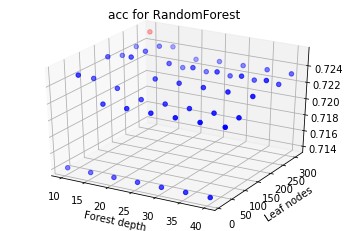

In [155]:
#Let us iterate to find the optimal forest parameters

step_leaf_nodes = 50
step_depth = 5
candidate_max_leaf_nodes = np.arange(10,(step_leaf_nodes*7)+10,step_leaf_nodes)
candidate_max_depth = np.arange(10,(step_depth*7)+10,step_depth)

# Write loop to find the ideal forest size from candidate_max_leaf_nodes and max_depth
acc=[]
depth_points=[]
leaf_points=[]
max_acc=0
for i, x_i  in enumerate(candidate_max_depth):
    for j, y_i  in enumerate(candidate_max_leaf_nodes):
        depth_points.append(candidate_max_depth[i])
        leaf_points.append(candidate_max_leaf_nodes[j])
        acc.append(get_accuracy_forest(x_i, y_i, train_X, test_X, train_y, test_y))
        if max(acc) > max_acc:
            min_acc = min(acc)
            # Store the best value of max_leaf_nodes and tree size
            best_depth = candidate_max_depth[i]
            best_forest_size = candidate_max_leaf_nodes[j]

#Show the minimum acc highlighted in red and plot in 3D the acc corresponding to the leaf nodes and depth fo the Random Forest
maxacc = np.max(acc)
mask = np.array(acc) == maxacc
color = np.where(mask, 'red', 'blue')
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(depth_points,leaf_points ,acc, color=color);
ax.set_title('acc for RandomForest');
ax.set_xlabel('Forest depth');
ax.set_ylabel('Leaf nodes');
#ax.set_zlim(zmin= 0.2, zmax=0.5)

In [156]:
#Create optimal random forest model
improved_forest_model = RandomForestClassifier(max_depth=best_depth, max_leaf_nodes=best_forest_size, random_state=0)

# fit the final model with the whole dataset and calculate error
improved_forest_model.fit(train_X, train_y)
val_predictions = improved_forest_model.predict(test_X)
val_mse = accuracy_score(val_predictions, test_y)
print("Validation accuracy: {:,.5f} - Best depth: {:,.0f} - Best forest size: {:,.0f}".format(val_mse, best_depth,best_forest_size))

Validation accuracy: 0.72318 - Best depth: 40 - Best forest size: 310


In [157]:
#Let us use Randomized Grid search to optimize several hyperparameters

# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_leaf_nodes" : randint(1,300),
              "max_depth": [3, 40],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

# Instantiate the RandomizedSearchCV object: forest_cv
forest_cv = RandomizedSearchCV(improved_forest_model, param_dist, cv=5, random_state=1, scoring='recall')

# Fit it to the data
forest_cv.fit(train_X,train_y)

# Print the tuned parameters and score
print("Tuned Decision Forest Parameters: {}".format(forest_cv.best_params_))
print("Best score is {}".format(forest_cv.best_score_))

Tuned Decision Forest Parameters: {'criterion': 'gini', 'max_depth': 40, 'max_features': 4, 'max_leaf_nodes': 122, 'min_samples_leaf': 1}
Best score is 0.7045527242339114


In [158]:
print(confusion_matrix(test_y,val_predictions))
print(classification_report(test_y,val_predictions))

[[4845 1622]
 [2076 4816]]
              precision    recall  f1-score   support

           0       0.70      0.75      0.72      6467
           1       0.75      0.70      0.72      6892

    accuracy                           0.72     13359
   macro avg       0.72      0.72      0.72     13359
weighted avg       0.72      0.72      0.72     13359



In [159]:
#Create forest model with the best hyperparameters
best_forest_model = forest_cv.best_estimator_.fit(train_X,train_y)

# fit the final model with the whole dataset and calculate error
val_predictions = best_forest_model.predict(test_X)
val_acc = accuracy_score(val_predictions, test_y)
print("Validation accuracy: {:,.5f}".format(val_acc))

Validation accuracy: 0.72625


In [160]:
#Also check the model with cross validation
cross_val_score(best_forest_model, X, y, cv=10, scoring='recall').mean()

0.7009340133994927

In [161]:
model_score['RandomForest'] =  [val_acc]

In [162]:
model_score

,K-Neighbors,DecisionTree,RandomForest
Model Score,0.640243,0.722285,0.726252


### Logistic regression

In [163]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression()
log.fit(train_X, train_y)

# Predicting the Test set results
val_predictions = log.predict(test_X)

val_acc = accuracy_score(val_predictions, test_y)
print("Validation accuracy: {:,.5f}".format(val_acc))

Validation accuracy: 0.71809


Text(0.5, 1.0, 'ROC Curve')

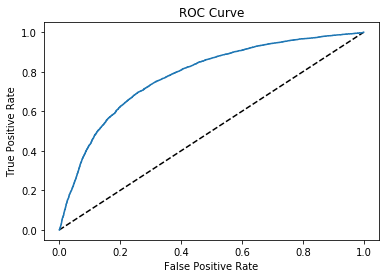

In [164]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Compute predicted probabilities: y_pred_prob
y_pred_prob = log.predict_proba(test_X)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(test_y, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

In [165]:
#We compute the area under the ROC
roc_auc_score(test_y, y_pred_prob)

0.7813129647630216

In [166]:
#Let us check the best performance using a grid search
# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(log, param_grid, cv=5)

# Fit it to the data
logreg_cv.fit(train_X,train_y)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))


Tuned Logistic Regression Parameters: {'C': 31.622776601683793}
Best score is 0.7213145434469336


In [167]:
print(confusion_matrix(test_y,val_predictions))
print(classification_report(test_y,val_predictions))

[[4789 1678]
 [2088 4804]]
              precision    recall  f1-score   support

           0       0.70      0.74      0.72      6467
           1       0.74      0.70      0.72      6892

    accuracy                           0.72     13359
   macro avg       0.72      0.72      0.72     13359
weighted avg       0.72      0.72      0.72     13359



In [168]:
#Also check the model with cross validation for the best logistic model
log_scores = cross_val_score(best_logistic_model, X, y, cv=10, scoring='recall')

In [169]:
#Create logistic regression model with the best hyperparameters
best_logistic_model = logreg_cv.best_estimator_.fit(train_X,train_y)

# fit the final model with the whole dataset and calculate error
val_predictions = best_logistic_model.predict(test_X)
val_acc = accuracy_score(val_predictions, test_y)
print("Validation accuracy: {:,.5f}".format(val_acc))

Validation accuracy: 0.71824


In [170]:
model_score['LogisticRegression'] =  [val_acc]

In [171]:
 model_score

,K-Neighbors,DecisionTree,RandomForest,LogisticRegression
Model Score,0.640243,0.722285,0.726252,0.718242


### K-Neighbors

In [133]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#For this model we are scaling, since for the neighbor model having comparable values should be more accurate

# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=3))]
        
# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Fit the pipeline to the training set: knn_scaled
knn_scaled = pipeline.fit(train_X,train_y)

# Instantiate and fit a k-NN classifier to the unscaled data
knn_unscaled = KNeighborsClassifier(n_neighbors=3)
knn_unscaled.fit(train_X, train_y)

# Compute and print metrics
print('Accuracy with Scaling: {}'.format(knn_scaled.score(test_X,test_y)))
print('Accuracy without Scaling: {}'.format(knn_unscaled.score(test_X,test_y)))

# Predicting the Test set results
val_predictions = knn_scaled.predict(test_X)

val_acc = accuracy_score(val_predictions, test_y)
print("Validation accuracy: {:,.5f}".format(val_acc))

Accuracy with Scaling: 0.6302866981061457
Accuracy without Scaling: 0.6621004566210046
Validation accuracy: 0.63029


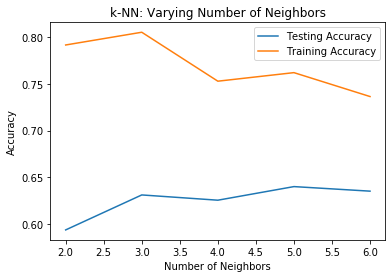

In [134]:
scaler = StandardScaler()

# Create X scaled
features = ['Age', 'Sex', 'Height', 'Weight','SystolicPressure', 'DiastolicPressure', 'Cholesterol', 'Diabetes', 'Smoker', 'Alcoholic',
           'ActiveSport']

X_scaled = scaler.fit_transform(X[features])
train_X, test_X, train_y, test_y = train_test_split(X_scaled, y, test_size=0.2, random_state=1)

#Let us iterate to find the best number of neighbors for the model and check performance for both training and test sets

neighbors = np.arange(2, 7)
train_accuracy = []
test_accuracy = []

# Loop over different values of k
for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    # Fit the classifier to the training data
    knn.fit(train_X,train_y)    
    #Compute accuracy on the training set
    train_accuracy.append(knn.score(train_X, train_y))
    #Compute accuracy on the testing set
    test_accuracy.append(knn.score(test_X, test_y))

# Generate plot
plt.title('k-NN: Varying Number of Neighbors');
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy');
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy');
plt.legend()
plt.xlabel('Number of Neighbors');
plt.ylabel('Accuracy');


In [135]:
print(confusion_matrix(test_y,val_predictions))
print(classification_report(test_y,val_predictions))

[[4072 2395]
 [2544 4348]]
              precision    recall  f1-score   support

           0       0.62      0.63      0.62      6467
           1       0.64      0.63      0.64      6892

    accuracy                           0.63     13359
   macro avg       0.63      0.63      0.63     13359
weighted avg       0.63      0.63      0.63     13359



In [136]:
#We take the best number of neighbors based on the previous graph. We select a trade off between training and test accuracy
best_neighbors = 5

#Create optimal random forest model
best_neighbor_model = KNeighborsClassifier(n_neighbors=best_neighbors)

# fit the final model with the whole dataset and calculate error
best_neighbor_model.fit(train_X, train_y)
val_predictions = best_neighbor_model.predict(test_X)
val_acc = accuracy_score(val_predictions, test_y)
print("Validation accuracy: {:,.5f} - Best number of neighbors: {:,.0f}".format(val_acc, best_neighbors))

Validation accuracy: 0.64024 - Best number of neighbors: 5


In [137]:
#Also check the model with cross validation
score_KNeighbors = cross_val_score(best_neighbor_model, X_scaled, y, cv=5)

In [138]:
model_score['K-Neighbors'] =  [val_acc]

In [139]:
model_score

,K-Neighbors
Model Score,0.640243


### Support Vector Machine (SVC)

In [84]:
from sklearn.svm import SVC
svc = SVC(kernel = 'rbf')
svc.fit(train_X, train_y)

# Predicting the Test set results
val_predictions = svc.predict(test_X)

val_mse = mean_squared_error(val_predictions, test_y)
print("Validation mse: {:,.3f}".format(val_mse))


Validation mse: 0.280


### Voting ensemble
We  combine the models to obtain a more accurate classifier

In [172]:
from sklearn.ensemble import VotingClassifier
# create the sub models, we select the three that perform better

estimators = []
estimators.append(('DecisionTree', best_tree_model))
estimators.append(('RandomForest', best_forest_model))
estimators.append(('LogisticRegression', best_logistic_model))

# create the ensemble model
ensemble = VotingClassifier(estimators)
ensembled_scores = cross_val_score(ensemble, X,y, cv=10)

# fit the final model with the whole dataset and calculate error
ensemble.fit(train_X, train_y)
val_predictions = ensemble.predict(test_X)
val_acc = accuracy_score(val_predictions, test_y)
print("Validation accuracy: {:,.5f}".format(val_acc))


model_score['EnsembledModels'] =  [val_acc]
model_score

Validation accuracy: 0.72595


,K-Neighbors,DecisionTree,RandomForest,LogisticRegression,EnsembledModels
Model Score,0.640243,0.722285,0.726252,0.718242,0.725953


### Light GBM

In [108]:
import lightgbm as lgb

d_train = lgb.Dataset(train_X, label = train_y)
params = {}

clf = lgb.train(params, d_train, 100)
#Prediction
val_predictions = clf.predict(test_X)

val_mse = mean_squared_error(val_predictions, test_y)
print("Validation mse: {:,.3f}".format(val_mse))

Validation MAE: 0.359


### XGBoost model

In [175]:
import xgboost as xgb
from xgboost import XGBClassifier

features = ['Age', 'Sex', 'Height', 'Weight','SystolicPressure', 'DiastolicPressure', 'Cholesterol', 'Smoker', 'Alcoholic',
           'ActiveSport']
X = df_stroke[features]

# Split into validation and training data
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=1)

In [176]:
#We select some values for the hyperparameters, they will be tuned later
xgbModel = XGBClassifier()
xgbModel.fit(train_X,train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [177]:
#We do a simple precition before tuning the model
val_predictions = xgbModel.predict(test_X)
val_acc = accuracy_score(val_predictions, test_y)
print("Validation accuracy: {:,.3f}".format(val_acc))

Validation accuracy: 0.729


In [22]:
# ! sudo apt-get install graphviz

[sudo] password for carcrupe: 


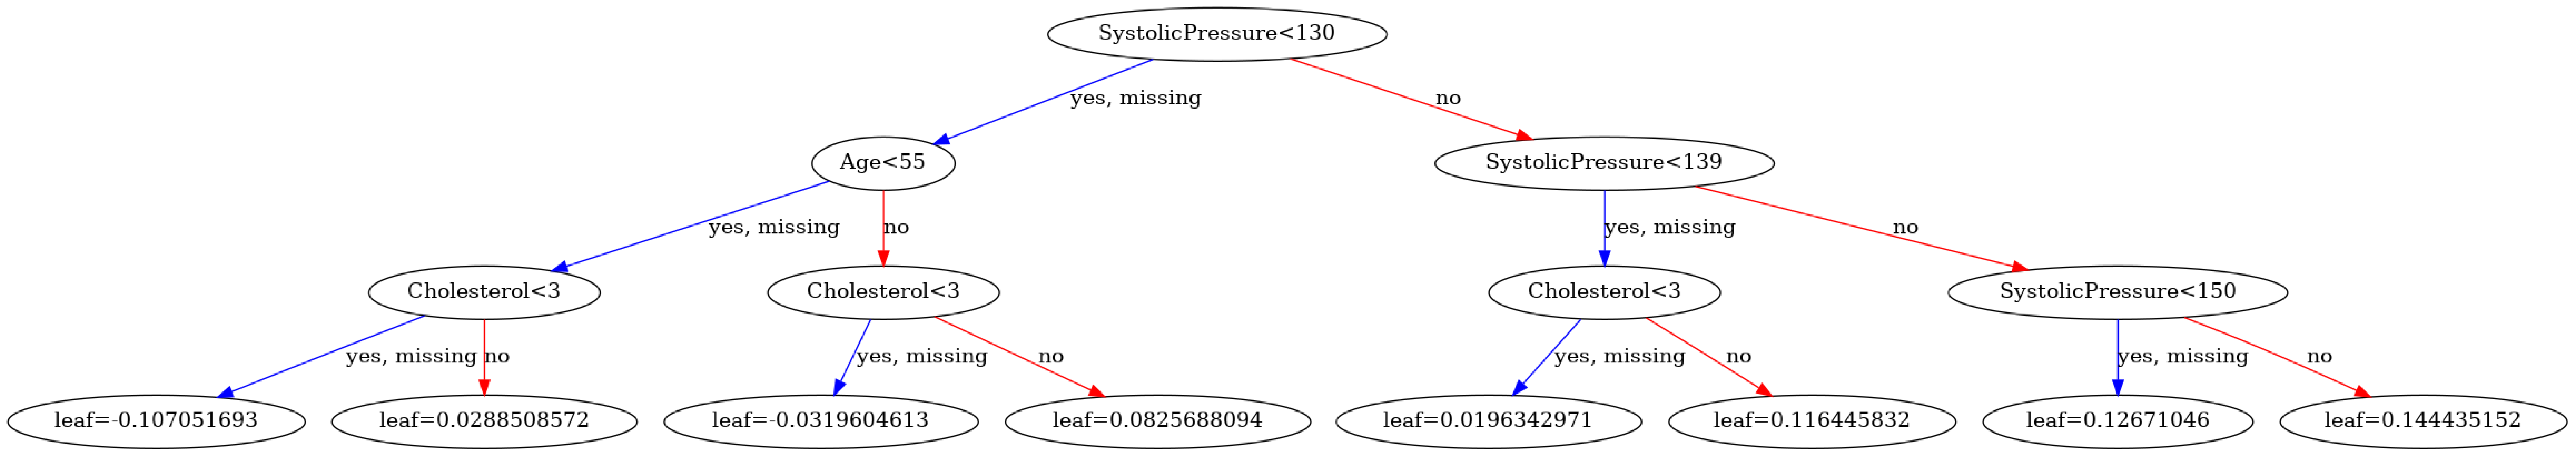

In [16]:
tree = xgb.plot_tree(xgbModel, num_trees=0)
fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')

Test-accuracy-mean: 0.729


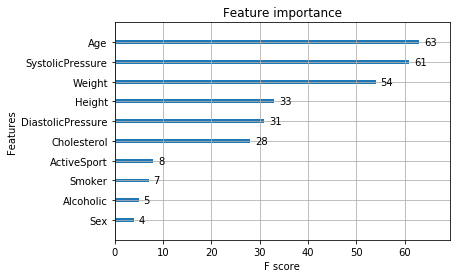

In [182]:
stroke_DMatrix = xgb.DMatrix(data= X,label =y)

stroke_train_DMatrix = xgb.DMatrix(data= train_X,label =train_y)
stroke_test_DMatrix = xgb.DMatrix(data= test_X,label =test_y)

# Create the parameter dictionary: params
params = {'objective':'binary:logistic', 'max_depth':4}


# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=stroke_train_DMatrix, params=params, 
                  nfold=3, num_boost_round=5, 
                  metrics="error",  seed=1, as_pandas=True)

# Print the accuracy taking the last value of the mean in the test error
print("Test-accuracy-mean: {:,.3f}".format(((1-cv_results["test-error-mean"]).iloc[-1])))

# Train the model and predict the test values
xg_clf = xgb.train(dtrain=stroke_train_DMatrix, params=params, num_boost_round=20)

# Plot the feature importances
xgb.plot_importance(xg_clf);

In [185]:
#We have explored the data and got the test prediction error. Let us now tune the model to improve the performance
#tuning the hyperparameters

gbm_param_grid = {
    'n_estimators': np.arange(10,1000,200),
    'max_depth': range(2, 12),
    'learning_rate': np.arange(0.1,0.5,0.1)
}

# Perform random search of hyperparameteres
r_xgb = RandomizedSearchCV(estimator=xgbModel, param_distributions=gbm_param_grid, cv=3, 
                                    n_iter=5, verbose=1, random_state=42, scoring='recall', n_jobs=-1)

# Fit best_xgb to the data
r_xgb.fit(X,y)

# Print the best parameters and highest recall
print("Best parameters found: ", r_xgb.best_params_)
print("Highest recall: ", np.sqrt(np.abs(r_xgb.best_score_)))

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.2min finished


Best parameters found:  {'n_estimators': 910, 'max_depth': 2, 'learning_rate': 0.11}
Highest recall:  0.8451789667315349


In [186]:
best_xgb = r_xgb.best_estimator_.fit(train_X,train_y)
val_predictions = best_xgb.predict(test_X)
val_acc = accuracy_score(val_predictions, test_y)
print("Validation accuracy: {:,.3f}".format(val_acc))

Validation accuracy: 0.728


In [187]:
model_score['XGBBoost'] =  [val_acc]

In [188]:
model_score

,K-Neighbors,DecisionTree,RandomForest,LogisticRegression,EnsembledModels,XGBBoost
Model Score,0.640243,0.722285,0.726252,0.718242,0.725953,0.727812


In [189]:
final_scores = pd.DataFrame(model_score).transpose()

In [190]:
final_scores.sort_values(by='Model Score' ,ascending=False, inplace=True)
final_scores

,Model Score
XGBBoost,0.727812
RandomForest,0.726252
EnsembledModels,0.725953
DecisionTree,0.722285
LogisticRegression,0.718242
K-Neighbors,0.640243
